In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import autocast, GradScaler
import deeplake
from torchvision.ops import DeformConv2d
from torchvision import transforms
import matplotlib.pyplot as plt
!pip install timm
import timm
from collections import OrderedDict

/home/remelias/slab_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print(f"GPU is available with {num_gpus} {'GPU' if num_gpus == 1 else 'GPUs'}.")
    
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("No GPU available. Using CPU.")

GPU is available with 4 GPUs.
GPU 0: NVIDIA GeForce RTX 3090
GPU 1: NVIDIA GeForce RTX 3090
GPU 2: NVIDIA GeForce RTX 3090
GPU 3: NVIDIA GeForce RTX 3090


In [3]:
class DataLoaderWrapper:
    def __init__(self,batch_size=32, image_size=50) -> None:
        self.batch_size=batch_size
        self.tform={
                        'train': transforms.Compose([
                        transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
                        transforms.Resize((image_size,image_size)),
                        transforms.RandomRotation(20), # Image augmentation
                        transforms.RandomHorizontalFlip(p=0.5), # Image augmentation
                        transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
                        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                        ]),
                        'test': transforms.Compose([
                        transforms.ToPILImage(), # Must convert to PIL image for subsequent operations to run
                        transforms.Resize((image_size,image_size)),
                        transforms.ToTensor(), # Must convert to pytorch tensor for subsequent operations to run
                        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
                        ])
                   }

        self.ds_adience =deeplake.load('hub://activeloop/adience', reset=True)
        # self.ds_celebA_train = deeplake.load("hub://activeloop/celeb-a-train", reset=True)
        # self.ds_celebA_val = deeplake.load("hub://activeloop/celeb-a-val", reset=True)
        # self.ds_celebA_test = deeplake.load("hub://activeloop/celeb-a-test", reset=True)

    def initialize_celebA_dataloaders(self):
        celebA_train_dataloader = self.ds_celebA_train.pytorch(batch_size=self.batch_size, num_workers=8, transform={'images':self.tform['train'],'male':None,'young':None}, shuffle=True,lazy=True,pin_memory=True,prefetch_factor=2)
        celebA_val_dataloader = self.ds_celebA_val.pytorch(batch_size=self.batch_size, num_workers=8, transform={'images':self.tform['test'],'male':None,'young':None}, shuffle=True,lazy=True,pin_memory=True,prefetch_factor=2)
        celebA_test_dataloader = self.ds_celebA_test.pytorch(batch_size=self.batch_size, num_workers=8, transform={'images':self.tform['test'],'male':None,'young':None}, shuffle=True,lazy=True,pin_memory=True,prefetch_factor=2)
        return celebA_train_dataloader,celebA_val_dataloader,celebA_test_dataloader

    def initialize_adience_dataloaders(self):
        adience_train, adience_test = self.ds_adience.random_split([0.7,0.3])
        adience_train_dataloader = adience_train.pytorch(batch_size=self.batch_size, num_workers=16, transform={'images':self.tform['train'], 'genders':None, 'ages':None},lazy=True,pin_memory=True,prefetch_factor=2)
        #adience_val_dataloader = adience_val.pytorch(batch_size=self.batch_size, num_workers=16, transform={'images':self.tform['test'], 'genders':None, 'ages':None},lazy=True,pin_memory=True,prefetch_factor=2)
        adience_test_dataloader = adience_test.pytorch(batch_size=self.batch_size, num_workers=16, transform={'images':self.tform['test'], 'genders':None, 'ages':None},lazy=True,pin_memory=True,prefetch_factor=2)
        return adience_train_dataloader, adience_test_dataloader

In [4]:
data=DataLoaderWrapper(batch_size=128)
#celebA_train,celebA_val,celebA_test=data.initialize_celebA_dataloaders()
adience_train,adience_test=data.initialize_adience_dataloaders()

\

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/adience



/

hub://activeloop/adience loaded successfully.



-/home/remelias/slab_gpu/lib/python3.8/site-packages/deeplake/integrations/pytorch/common.py:126: UserWarning: Decode method for tensors ['images'] is defaulting to numpy. Please consider specifying a decode_method in .pytorch() that maximizes the data preprocessing speed based on your transformation.
  warnings.warn(


In [5]:
def train(dataloader, model, criterion, optimizer):
    train_running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    for i, data in enumerate(dataloader):
        inputs, genders,ages = data['images'],data['genders'].long(),data['ages'].long()
        labels=torch.cat((genders,ages),1)
        _, labels = torch.max(labels, 1) #one hot encode labels
        logits = model(inputs)
        _,preds=torch.max(logits,1)
        loss = criterion(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * inputs.size(0)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    train_loss = train_running_loss / len(dataloader.dataset)
    train_accuracy = (correct_predictions / total_predictions) * 100
    return train_loss, train_accuracy

def test(dataloader, model, criterion):
    test_loss = 0.0
    correct_test_predictions = 0
    total_test_predictions = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            inputs, genders, ages = data['images'], data['genders'].long(), data['ages'].long()
            labels = torch.cat((genders, ages), 1)
            _, labels = torch.max(labels, 1)
            logits = model(inputs)
            _, preds = torch.max(logits, 1)
            loss = criterion(logits, labels)

            test_loss += loss.item() * inputs.size(0)
            correct_test_predictions += (preds == labels).sum().item()
            total_test_predictions += labels.size(0)

    test_loss = test_loss / len(dataloader.dataset)
    test_accuracy = (correct_test_predictions / total_test_predictions) * 100
    return test_loss, test_accuracy

In [6]:
def train_test(model):
    criterion=nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

    num_epochs = 3

    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_accuracy = train(adience_train, model, criterion, optimizer)
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

        model.eval()
        test_loss, test_accuracy = test(adience_test, model, criterion)
        print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        scheduler.step()

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
    plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss')
    plt.legend()

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
    plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Test Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### ResNet

/home/remelias/slab_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/remelias/slab_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3, Train Loss: 0.8075, Train Accuracy: 60.37%
Epoch 1/3, Test Loss: 0.6272, Test Accuracy: 64.83%
Epoch 2/3, Train Loss: 0.6657, Train Accuracy: 64.59%
Epoch 2/3, Test Loss: 0.6037, Test Accuracy: 67.56%
Epoch 3/3, Train Loss: 0.6367, Train Accuracy: 65.95%
Epoch 3/3, Test Loss: 0.5815, Test Accuracy: 69.02%


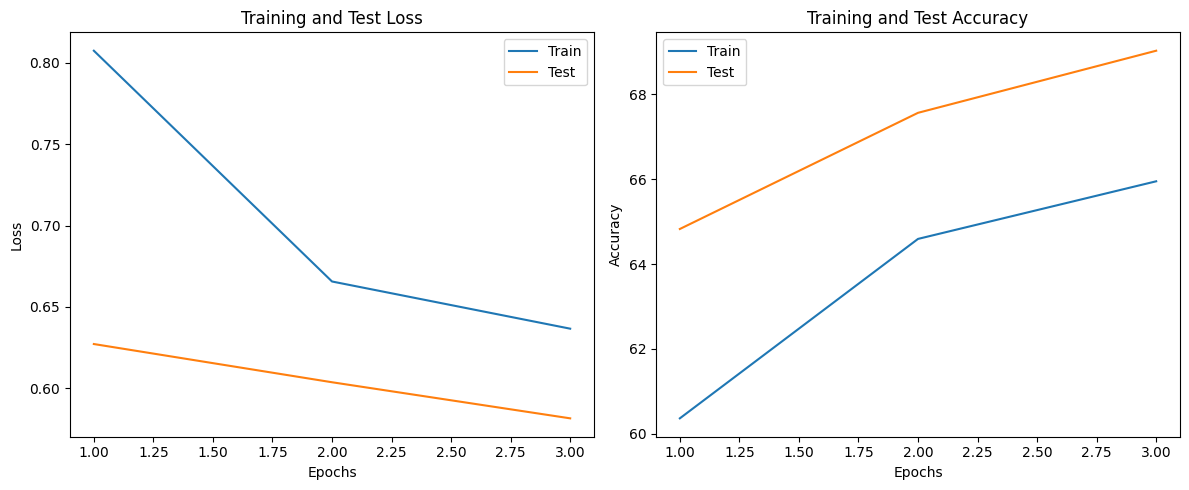

In [7]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4*8)

train_test(model)

### mobileNet

/home/remelias/slab_gpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3, Train Loss: 0.7855, Train Accuracy: 62.43%
Epoch 1/3, Test Loss: 0.6224, Test Accuracy: 66.75%
Epoch 2/3, Train Loss: 0.6860, Train Accuracy: 63.40%
Epoch 2/3, Test Loss: 0.6035, Test Accuracy: 64.41%
Epoch 3/3, Train Loss: 0.6421, Train Accuracy: 64.89%
Epoch 3/3, Test Loss: 0.6046, Test Accuracy: 65.88%


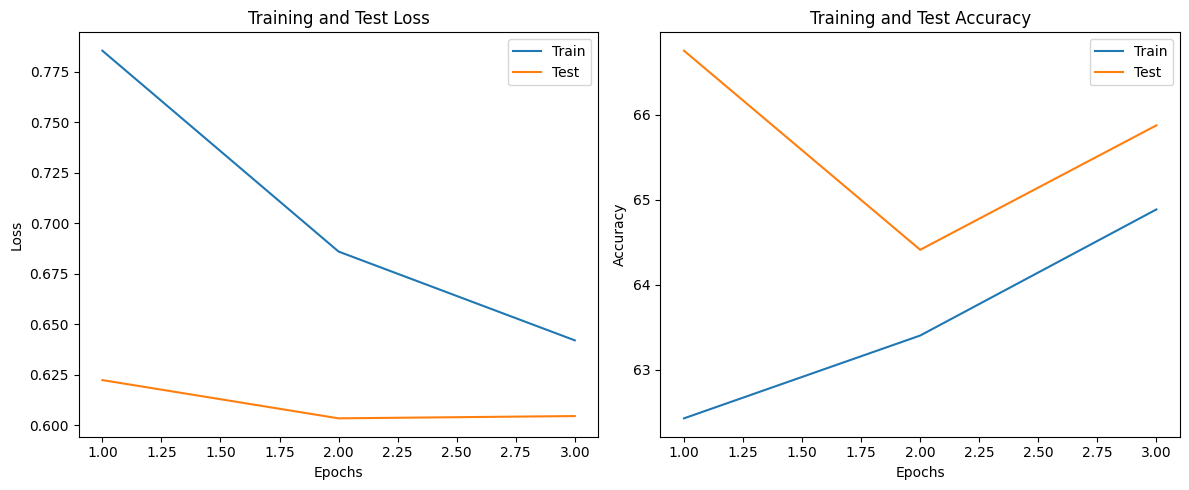

In [8]:
model = models.mobilenet_v2(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 4*8)

train_test(model)

### viT

In [9]:
data=DataLoaderWrapper(batch_size=64,image_size=224)
#celebA_train,celebA_val,celebA_test=data.initialize_celebA_dataloaders()
adience_train,adience_test=data.initialize_adience_dataloaders()

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/adience



\

hub://activeloop/adience loaded successfully.



In [10]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
num_classes = 4*8  # 8 different age groups * 4 different gender classes
model.head = nn.Linear(model.head.in_features, num_classes)

train_test(model)

### Levi Hassner

In [ ]:
class Levi_Hassner(nn.Module):
    def __init__(self,output=2,deformable=False) -> None:
        super().__init__()
        self.deformable=deformable

        self.layers=nn.Sequential(OrderedDict([
            # first convolutional layer
            ('conv1',nn.Conv2d(3, 96, 7, padding='valid', stride=4)),  # No padding
            ('relu1',nn.ReLU()),
            ('maxpool1',nn.MaxPool2d(3, stride=2)),  # Max pooling over a (3, 3) window with 2 pixel stride)
            ('lrn1',nn.LocalResponseNorm(size=5, k=2, alpha=10**(-4), beta=0.75)),

            # second convolutional layer
            ('conv2',nn.Conv2d(96, 256, 5, padding='same')), # Same padding
            ('relu2',nn.ReLU()),
            ('maxpool2',nn.MaxPool2d(3, stride=2)),  # Max pooling over a (3, 3) window with 2 pixel stride)
            ('lrn2',nn.LocalResponseNorm(size=5, k=2, alpha=10**(-4), beta=0.75)),

            # third convolutional layer
            ('conv3',nn.Conv2d(256, 384, 3, padding='same')),  # Same padding
            ('relu3',nn.ReLU()),
            ('maxpool3',nn.MaxPool2d(3, stride=2)),  # Max pooling over a (3, 3) window with 2 pixel stride)
            ('flatten',nn.Flatten()),

            ('fc1',nn.Linear(384*6*6, 512)), # input 384 * 6 * 6 = 13824, output 512
            ('relu4',nn.ReLU()),
            ('dropout1',nn.Dropout(0.5)),

            ('fc2',nn.Linear(512,512)),
            ('relu5',nn.ReLU()),
            ('dropout2',nn.Dropout(0.5)),
            
            ('fc3',nn.Linear(512,output)), # output = number of classes 
        ]))
        self.prob=nn.Softmax(dim=1) # new stuff to check if its causes harm

    def forward(self,x):
        x=self.layers(x)
        prob=self.prob(x)
        return prob